# VAR model
https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

In [9]:
import os
import sys
sys.path.append('..')
from tqdm import tqdm
from datetime import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from src.support_function import *
import warnings
warnings.filterwarnings('ignore')

## 读取数据

In [10]:
root_1 = '../Dataset'
df_ori = pd.read_csv(os.path.join(root_1, '3bs_8q_4p_test_resid.csv'),
                parse_dates=['datetime'])
df_train = pd.read_csv(os.path.join(root_1, '3bs_8q_4p_train_resid.csv'),
                parse_dates=['datetime'])
# Column names for all sensors
columns = ['q'+str(i) for i in range(1,12)] + ['p'+str(j) for j in range(1,8)]

In [3]:
df_ori.head(2)

,datetime,p1,p2,p3,p4,p5,p6,p7,q1,q10,...,q4,q5,q6,q7,q8,q9,q8_seasonal,q8_ori,p5_seasonal,p5_ori
0,2019-01-01 00:30:00,-0.208963,-0.226402,-0.083406,-0.139544,-0.335937,0.041241,0.016622,-0.049463,-0.018966,...,-0.049428,0.038180,0.016469,-0.028413,-0.004576,-0.002180,-0.062410,0.224880,-0.033273,0.372107
1,2019-01-01 01:00:00,0.022636,0.020021,-0.098132,-0.036963,-0.001460,0.126563,0.028108,-0.020315,-0.002354,...,-0.007227,0.035003,0.014642,-0.027348,-0.018031,-0.023899,-0.039385,0.167464,-0.000815,0.369831


# VAR模型

## 实验2：Decompose (diff=1 - seasonal) + VAR

In [32]:
# The training set is used for training the VAR model
# The valid set is only for predict and valid
model = VAR(df_train[columns].interpolate().fillna(0).values)
hist_lag = 48*3
# hist_lag = 100 # 0.03501
# hist_lag = 80 # 0.03506
hist_lag = 40 # 0.0346
# hist_lag = 40 # 0.0422

model_fitted = model.fit(hist_lag)

In [33]:
df = df_ori.copy()
future_lag = 4
target = 'p5'
timestamp_list = []
resid_pred_list = []
for i in tqdm(range(0, df.shape[0]-hist_lag-future_lag)):
    forecast_input = df[columns].copy().values[i: i+hist_lag]
    forecast_timestamp = datetime.timestamp(df['datetime'].iloc[i+hist_lag])
    forecast_output = pd.DataFrame(model_fitted.forecast(y=forecast_input, steps=future_lag),
                                   columns=columns)
    timestamp_list += [forecast_timestamp]
    resid_pred_list += [forecast_output[target].values]

100%|█████████████████████████████████████████████████████████████████████████████| 4449/4449 [00:05<00:00, 772.32it/s]


{'MAE': 0.06437198439548443, 'MSE': 0.00734100979540027}
{'MAE': 0.06437198439548443, 'MSE': 0.00734100979540027}
{'MAE': 0.0643719843954844, 'MSE': 0.007341009795400269}
{'MAE': 0.0784534019474353, 'MSE': 0.01062428572173548}
{'MAE': 0.0784534019474353, 'MSE': 0.01062428572173548}
{'MAE': 0.07845340194743529, 'MSE': 0.010624285721735478}
{'MAE': 0.09027714836584214, 'MSE': 0.013860908343459207}
{'MAE': 0.09027714836584214, 'MSE': 0.013860908343459207}
{'MAE': 0.09027714836584214, 'MSE': 0.013860908343459207}
{'MAE': 0.09703789790986853, 'MSE': 0.01575208166872412}
{'MAE': 0.09703789790986853, 'MSE': 0.01575208166872412}
{'MAE': 0.09703789790986854, 'MSE': 0.015752081668724126}
mae 0.08253510815465759 mse 0.01189457138232977

{'MAE': 0.06501699218412843, 'MSE': 0.007506302480229521}
{'MAE': 0.0734582622748029, 'MSE': 0.009850794164435999}
{'MAE': 0.0739694349357014, 'MSE': 0.010040626596078923}
{'MAE': 0.07257935981379825, 'MSE': 0.009814064258273782}


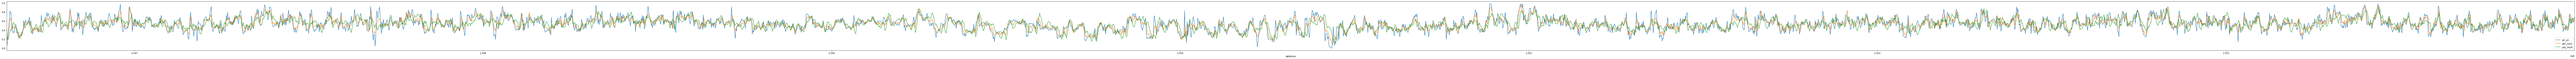

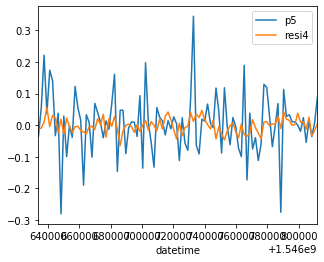

In [34]:
# def reconstruct(timestamp_list, resid_pred_list):
# import pdb
df1 = pd.read_csv(os.path.join('../Dataset', '3bs_8q_4p_test_resid.csv'),
                     parse_dates=['datetime'])
df1.index = df1['datetime'].apply(datetime.timestamp)
resid_columns = ['resi1', 'resi2', 'resi3', 'resi4']
df2 = pd.DataFrame(np.array(resid_pred_list), index=np.array(timestamp_list), columns=resid_columns)
df3 = df1.join(df2)
start = 200
end = -200
df3['temp'] = 0
df3['0'] = 0
mean_mse = 0
mean_mae = 0
for index, i in enumerate(resid_columns):
    # 方法一：ori 与 ori 比较
    df3['temp'] += df3[i].copy()
    df3['pre_'+ i] = (df3['temp'] + df3[target + '_seasonal'].shift(-index).rolling(index+1).sum() + 
                      df3[target + '_ori'].copy().shift(1)).shift(index)
    eval_dict = eval_metrics(df3['pre_' + i].iloc[start:end].values, df3[target+'_ori'].iloc[start:end].values)
    print(eval_dict)
    # 方法二：diff 与 diff 比较
    pred = (df3['temp'] + df3[target+'_seasonal'].shift(-index).rolling(index+1).sum()).shift(index)
    eval_dict = eval_metrics(pred.iloc[start:end].values, df3[target+'_ori'].diff(index+1).iloc[start:end].values)
    print(eval_dict)
    
#     方法三：resid 与 resid 比较
    pred = (df3['temp']).shift(index)
    eval_dict = eval_metrics(pred.iloc[start:end].values, df3[target].rolling(index+1).sum().iloc[start:end].values)
    print(eval_dict)
    
    mean_mae += eval_dict['MAE']/4
    mean_mse += eval_dict['MSE']/4
print('mae', mean_mae, 'mse', mean_mse)

print()
print(eval_metrics(df3['resi1'].shift(0).iloc[start:-20].values, df3[target].iloc[start:-20].values))
print(eval_metrics(df3['resi2'].shift(1).iloc[start:-20].values, df3[target].iloc[start:-20].values))
print(eval_metrics(df3['resi4'].shift(3).iloc[start:-20].values, df3[target].iloc[start:-20].values))
print(eval_metrics(df3['0'].iloc[start:-20].values, df3[target].iloc[start:-20].values))

def plot_series(df_list, start, end):
    length = df_list[0].iloc[start: end].shape[0]
    plt.figure(figsize=(int(length/20),4), 
               facecolor='w')
    for i in df_list:
        i.iloc[start: end].plot()
    plt.legend([i.name for i in df_list])
    plt.show()
    
plot_series([df3[target+'_ori'], df3['pre_resi1'], df3['pre_resi4']], start, end)
plot_series([df3[target], df3['resi4'].shift(3)], start, 300)

# q8:
# recons_resid
# {'MAE': 0.024999614252763248, 'MSE': 0.001117608556620073, 'MAPE': 0.2763045802559503}
# {'MAE': 0.033175048022963644, 'MSE': 0.001984701100148979, 'MAPE': -0.10648945625355516}
# {'MAE': 0.040144970376886344, 'MSE': 0.0028861608449992624, 'MAPE': 0.07923126836191059}
# {'MAE': 0.04458878661488337, 'MSE': 0.0035691977057236554, 'MAPE': -0.24869565464059912}
# mae 0.03572710481687412 mse 0.0023894170518729955

# # # no resid
# {'MAE': 0.029096205758493154, 'MSE': 0.0016235926440710236, 'MAPE': 0.1424925506614955}
# {'MAE': 0.04246182726649544, 'MSE': 0.0038173316862700306, 'MAPE': 0.1453691246159831}
# {'MAE': 0.055869167168573576, 'MSE': 0.0066678820479848504, 'MAPE': -0.17655927074633385}
# {'MAE': 0.0659051313713681, 'MSE': 0.009500575206451874, 'MAPE': 0.11573459566074626}
# mae 0.048333082891232455 mse 0.005402345396194445

# p5:
# mae 0.08432854998148615 mse 0.012148436444302706
# p5 noresid
# mae 0.09702693980191313 mse 0.016904416725203854


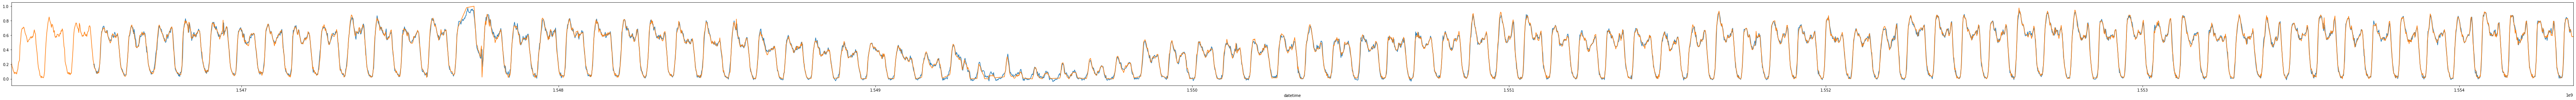

In [22]:
ori1 = df3['q8_seasonal'] + df3['resi1'] + df3['q8_ori'].shift(1).copy() # 验证了没问题
ori2 = df3['q8_ori']
plt.figure(figsize=(120,4))
ori1.plot()
ori2.plot()

In [19]:
df3.iloc[:,:-8]

,datetime,p1,p2,p3,p4,p5,p6,p7,q1,q10,...,q6,q7,q8,q9,q8_seasonal,q8_ori,p5_seasonal,p5_ori,resi1,resi2
datetime,,,,,,,,,,,,,,,,,,,,,
1.546274e+09,2019-01-01 00:30:00,-0.208963,-0.226402,-0.083406,-0.139544,-0.335937,0.041241,0.016622,-0.049463,-0.018966,...,0.016469,-0.028413,-0.004576,-0.002180,-0.062410,0.224880,-0.033273,0.372107,NaN,NaN
1.546276e+09,2019-01-01 01:00:00,0.022636,0.020021,-0.098132,-0.036963,-0.001460,0.126563,0.028108,-0.020315,-0.002354,...,0.014642,-0.027348,-0.018031,-0.023899,-0.039385,0.167464,-0.000815,0.369831,NaN,NaN
1.546277e+09,2019-01-01 01:30:00,-0.003481,-0.010326,0.003266,-0.028086,-0.059661,-0.064741,0.020384,0.008402,0.005229,...,-0.033240,0.113182,0.010245,0.045289,-0.024599,0.153110,0.008364,0.318535,NaN,NaN
1.546279e+09,2019-01-01 02:00:00,0.002737,-0.004938,0.001022,0.006409,0.036998,-0.071312,0.016490,0.009615,-0.023567,...,0.013429,0.091819,-0.022999,-0.001361,-0.015278,0.114833,0.002715,0.358248,NaN,NaN
1.546281e+09,2019-01-01 02:30:00,-0.012120,0.246176,-0.000822,0.013877,-0.001894,0.020266,-0.011551,0.002116,-0.012946,...,-0.007813,-0.027570,-0.011449,-0.027386,-0.002905,0.100478,0.011409,0.367763,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.554352e+09,2019-04-04 12:30:00,0.018037,-0.224624,0.019477,0.000880,0.025370,0.023799,-0.017985,-0.025472,-0.001209,...,0.043045,-0.039574,-0.007883,-0.063443,-0.035179,0.641148,0.019804,0.457532,-0.000698,0.002453
1.554354e+09,2019-04-04 13:00:00,0.282959,0.240986,0.037695,0.053821,0.045497,0.210314,0.004413,0.019889,0.004425,...,-0.052256,-0.023342,-0.005757,0.032367,-0.046874,0.588517,-0.000612,0.502416,NaN,NaN
1.554356e+09,2019-04-04 13:30:00,-0.196256,0.010056,0.042457,-0.001229,0.010183,0.058330,0.013237,0.002151,0.009341,...,-0.011543,-0.007433,0.019503,0.013706,-0.029072,0.578947,-0.046380,0.466219,NaN,NaN


In [ ]:
# aa = pd.read_csv('../result/EDLSTM_nD_notf.csv')